In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator

In [82]:
def plot_performance(ax, df, label, metric, color, static=False, H=64, ls='standard', z=1):
    
    if static:
        df = df.groupby('trial').aggregate(np.nanmean).reset_index()
        avg = np.array([np.nanmean(df[metric].values)]*H)
        std = np.array([np.nanstd(df[metric].values)]*H)
        ls = '--' if ls == 'standard' else ls
    else:
        grouped = df.groupby('horizon')        
        avg = grouped[metric].aggregate(np.nanmean).values[-H:]
        std = grouped[metric].aggregate(np.nanstd).values[-H:]
        ls = '-' if ls == 'standard' else ls
    
    line = ax.plot(range(1,H+1), avg, label=label, ls=ls, color=color, linewidth=1.8, zorder=z)
    ax.fill_between(range(1, H+1), avg-std, avg+std, color=color, alpha=0.2, zorder=z)

In [3]:
base_dir = '/home/fiona/birdMigration/results'

### ***Predictive performance***

In [4]:
models = {'HA': '#984ea3', 'GAM': '#4daf4a', 'GBT': '#377eb8', 'FluxRGNN': '#ff7f00'}
static_models = ['HA', 'GAM', 'GBT']
C, H = 24, 72

bscale_radar = 322.2732238769531
bscale_abm = 0.2643902916959686

#### Simulated data

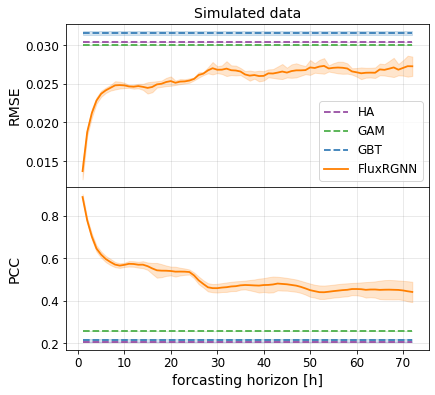

In [6]:
rmse_per_hour = pd.read_csv(osp.join(base_dir, 'abm', 'performance_evaluation', 'final', 'rmse_per_hour.csv'))
pcc_per_hour = pd.read_csv(osp.join(base_dir, 'abm', 'performance_evaluation', 'final', 'pcc_per_hour.csv'))

rmse_per_hour['rmse'] /= bscale_abm

fig, ax = plt.subplots(nrows=2, figsize=(6.5,6), sharex=True)

for i, (m, c) in enumerate(models.items()):
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}"'), 
                     m, 'rmse', static=(m in static_models), H=H, color=c)
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}"'), 
                     m, 'pcc', static=(m in static_models), H=H, color=c)
    
ax[0].set_ylabel('RMSE', fontsize=14)
ax[1].set_ylabel('PCC', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[0].legend(loc='lower right', fontsize=12)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)
    
fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
#fig.savefig('/home/fiona/birdMigration/data/plots/final/abm_rmse_pcc_per_hour_final.png', bbox_inches='tight', dpi=200)

#### Radar data

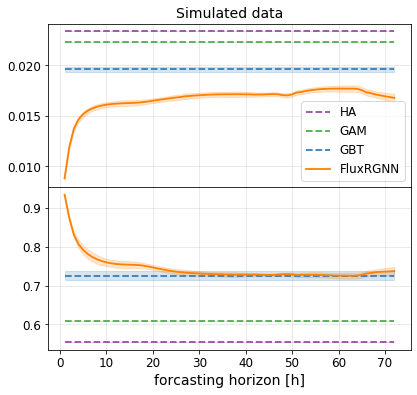

In [8]:
rmse_per_hour = pd.read_csv(osp.join(base_dir, 'radar', 'performance_evaluation', 'final', 'rmse_per_hour.csv'))
pcc_per_hour = pd.read_csv(osp.join(base_dir, 'radar', 'performance_evaluation', 'final', 'pcc_per_hour.csv'))

rmse_per_hour['rmse'] /= bscale_radar

fig, ax = plt.subplots(nrows=2, figsize=(6.5,6), sharex=True)

for i, (m, c) in enumerate(models.items()):
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}"'), 
                     m, 'rmse', static=(m in static_models), H=H, color=c)
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}"'), 
                     m, 'pcc', static=(m in static_models), H=H, color=c)
    
#ax[0].set_ylabel('RMSE', fontsize=14)
#ax[1].set_ylabel('PCC', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[0].legend(loc='lower right', fontsize=12)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)
    
fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
#fig.savefig('/home/fiona/birdMigration/data/plots/final/abm_rmse_pcc_per_hour_final.png', bbox_inches='tight', dpi=200)

### ***Ablation study***

In [113]:
baseline_models = {('HA', 'final'): 'HA',
          ('GAM', 'final'): 'GAM',
          ('GBT', 'final'): 'GBT'}
flux_models = {    
          ('FluxRGNN', 'final'): 'FluxRGNN', 
          ('LocalLSTM', 'final'): 'w/o fluxes',       
          ('FluxRGNN', 'final_without_encoder'): 'w/o encoder',
          ('FluxRGNN', 'final_without_boundary'): 'w/o boundary'}
baseline_colors = ['#cccccc', '#999999', '#404040']
baseline_ls = ['--', '-.', ':']
flux_colors = ['#ff7f00', '#b30000', '#999966', '#008080']

#### Simulated data

In [121]:
rmse_per_hour = pd.read_csv(osp.join(base_dir, 'abm', 'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
rmse_per_hour['rmse'] = rmse_per_hour['rmse'] / bscale_abm
grouped = rmse_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.rmse.aggregate(np.nanmean)
stds = grouped.rmse.aggregate(np.nanstd)
print('######## RMSE #######')
print(means, stds)

pcc_per_hour = pd.read_csv(osp.join(base_dir, 'abm', 'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
grouped = pcc_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.pcc.aggregate(np.nanmean)
stds = grouped.pcc.aggregate(np.nanstd)
print('######## PCC #######')
print(means, stds)

######## RMSE #######
model      experiment            
FluxRGNN   final                     0.025401
           final_without_boundary    0.026691
           final_without_encoder     0.027016
LocalLSTM  final                     0.028701
Name: rmse, dtype: float64 model      experiment            
FluxRGNN   final                     0.000279
           final_without_boundary    0.000545
           final_without_encoder     0.000683
LocalLSTM  final                     0.000309
Name: rmse, dtype: float64
######## PCC #######
model      experiment            
FluxRGNN   final                     0.535150
           final_without_boundary    0.516970
           final_without_encoder     0.447460
LocalLSTM  final                     0.346233
Name: pcc, dtype: float64 model      experiment            
FluxRGNN   final                     0.011738
           final_without_boundary    0.030924
           final_without_encoder     0.031686
LocalLSTM  final                     0.026265
Name:

In [122]:
df = rmse_per_hour.query('model == "FluxRGNN" & experiment == "final"')
df.groupby('trial')['rmse'].aggregate(np.nanmean)

trial
1    0.025804
2    0.025141
3    0.025656
4    0.025887
5    0.026137
Name: rmse, dtype: float64

In [123]:
df = pcc_per_hour.query('model == "FluxRGNN" & experiment == "final"')
df.groupby('trial')['pcc'].aggregate(np.nanmean)

trial
1    0.497495
2    0.541565
3    0.510179
4    0.492841
5    0.485078
Name: pcc, dtype: float64

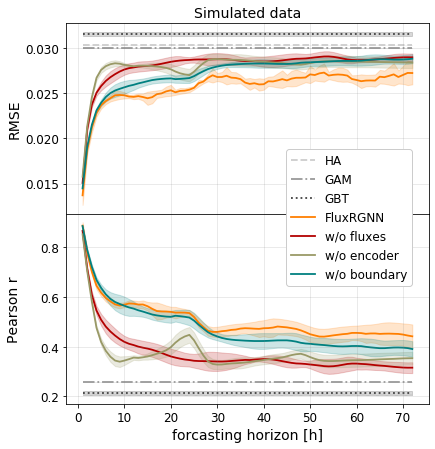

In [116]:
fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline_rmse = pd.read_csv(osp.join(base_dir, 'abm', 'performance_evaluation', 'final', 'rmse_per_hour.csv'))
baseline_pcc = pd.read_csv(osp.join(base_dir, 'abm', 'performance_evaluation', 'final', 'pcc_per_hour.csv'))

baseline_rmse['rmse'] /= bscale_abm

for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=(m in static_models), H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=(m in static_models), H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])

for i, ((m, e), label) in enumerate(flux_models.items()):
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=(m in static_models), H=H, color=flux_colors[i])
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=(m in static_models), H=H, color=flux_colors[i])


    
ax[0].set_ylabel('RMSE', fontsize=14)
ax[1].set_ylabel('Pearson r', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[1].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.37), framealpha=1)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig('/home/fiona/birdMigration/data/plots/final/abm_rmse_pcc_per_hour_combined.png', bbox_inches='tight', dpi=200)

#### Radar data

In [93]:
rmse_per_hour = pd.read_csv(osp.join(base_dir, 'radar', 'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
rmse_per_hour['rmse'] = rmse_per_hour['rmse'] / bscale_radar
grouped = rmse_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.rmse.aggregate(np.nanmean)
stds = grouped.rmse.aggregate(np.nanstd)
print('######## RMSE #######')
print(means, stds)

pcc_per_hour = pd.read_csv(osp.join(base_dir, 'radar', 'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
grouped = pcc_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.pcc.aggregate(np.nanmean)
stds = grouped.pcc.aggregate(np.nanstd)
print('######## PCC #######')
print(means, stds)

######## RMSE #######
model      experiment            
FluxRGNN   final                     0.016750
           final_without_boundary    0.019811
           final_without_encoder     0.017562
LocalLSTM  final                     0.016497
Name: rmse, dtype: float64 model      experiment            
FluxRGNN   final                     0.000249
           final_without_boundary    0.000605
           final_without_encoder     0.000292
LocalLSTM  final                     0.000494
Name: rmse, dtype: float64
######## PCC #######
model      experiment            
FluxRGNN   final                     0.737501
           final_without_boundary    0.724280
           final_without_encoder     0.698595
LocalLSTM  final                     0.744762
Name: pcc, dtype: float64 model      experiment            
FluxRGNN   final                     0.006569
           final_without_boundary    0.018734
           final_without_encoder     0.012926
LocalLSTM  final                     0.013191
Name:

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/fiona/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/fiona/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/fiona/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/fiona/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctio

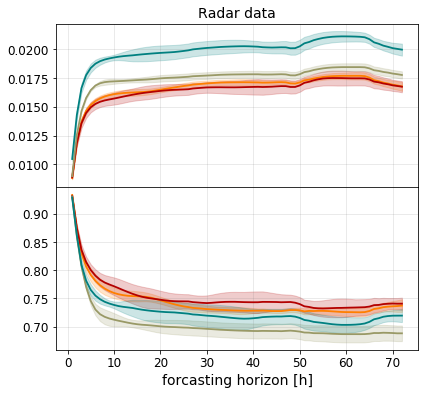

In [61]:
fig, ax = plt.subplots(nrows=2, figsize=(6.5,6), sharex=True)

for i, ((m, e), label) in enumerate(models.items()):
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=(m in static_models), H=H, color=colors[i])
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=(m in static_models), H=H, color=colors[i])
    
#ax[0].set_ylabel('RMSE', fontsize=14)
#ax[1].set_ylabel('PCC', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
#ax[0].legend(loc='lower right', fontsize=12)
ax[0].set_title('Radar data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig('/home/fiona/birdMigration/data/plots/final/radar_rmse_pcc_per_hour_ablations.png', bbox_inches='tight', dpi=200)

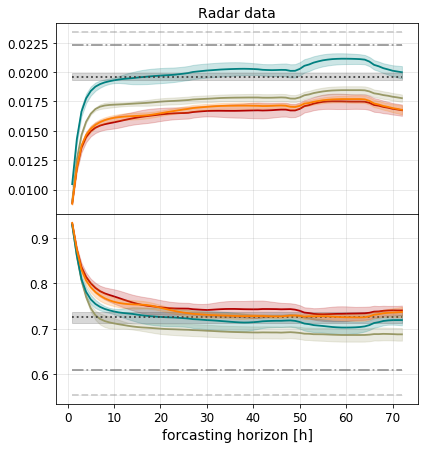

In [85]:
fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline_rmse = pd.read_csv(osp.join(base_dir, 'radar', 'performance_evaluation', 'final', 'rmse_per_hour.csv'))
baseline_pcc = pd.read_csv(osp.join(base_dir, 'radar', 'performance_evaluation', 'final', 'pcc_per_hour.csv'))

baseline_rmse['rmse'] /= bscale_radar

for i, ((m, e), label) in enumerate(flux_models.items()):
    if m == 'FluxRGNN' and e == 'final':
        z = 2
    else:
        z = 1
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=(m in static_models), H=H, color=flux_colors[i], z=z)
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=(m in static_models), H=H, color=flux_colors[i], z=z)
    
for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=(m in static_models), H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=(m in static_models), H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])


    
#ax[0].set_ylabel('RMSE', fontsize=14)
#ax[1].set_ylabel('PCC', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
#ax[1].legend(loc='upper right', fontsize=12, 
#            bbox_to_anchor=(0.97,1.44), framealpha=1)
ax[0].set_title('Radar data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig('/home/fiona/birdMigration/data/plots/final/radar_rmse_pcc_per_hour_combined.png', bbox_inches='tight', dpi=200)

In [119]:
df = rmse_per_hour.query('model == "FluxRGNN" & experiment == "final"')
df.groupby('trial')['rmse'].aggregate(np.nanmean)

trial
1    0.025804
2    0.025141
3    0.025656
4    0.025887
5    0.026137
Name: rmse, dtype: float64

In [120]:
df = pcc_per_hour.query('model == "FluxRGNN" & experiment == "final"')
df.groupby('trial')['pcc'].aggregate(np.nanmean)

trial
1    0.497495
2    0.541565
3    0.510179
4    0.492841
5    0.485078
Name: pcc, dtype: float64